In [5]:
import torch.nn as nn
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score as R2
from sklearn.metrics import mean_squared_error as MSE
from sklearn import preprocessing
from sklearn.multioutput import MultiOutputRegressor
import numpy as np
import torch
import matplotlib.pyplot as plt
import os
import time
import torch.optim as optim
import torch.nn.functional as F
from functools import reduce


import warnings
warnings.filterwarnings('ignore')

### Knowledge guided machine learning implementation using gated recurrent units
### Inspired from https://gmd.copernicus.org/articles/15/2839/2022

In [6]:
class KGML(nn.Module):
    def __init__(self, ninp, nhid, nlayers, nout, dropout):
        super(KGML, self).__init__()
        if nlayers > 1:
            self.gru = nn.GRU(ninp, nhid,nlayers,dropout=dropout)
        else:
            self.gru = nn.GRU(ninp, nhid,nlayers)
        #self.densor1 = nn.ReLU() #can test other function
        self.densor2 = nn.Linear(nhid, nout)
        self.nhid = nhid
        self.nlayers = nlayers
        self.drop=nn.Dropout(dropout)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1 #may change to a small value
        self.densor2.bias.data.zero_()
        self.densor2.weight.data.uniform_(-initrange, initrange)

    def forward(self, inputs, hidden):
        output, hidden = self.gru(inputs, hidden)
        #output = self.densor1(self.drop(output))
        #output = torch.exp(self.densor2(self.drop(output))) # add exp
        output = self.densor2(self.drop(output)) # add exp
        return output, hidden

#bsz should be batch size
    def init_hidden(self, bsz):
        weight = next(self.parameters())
        weight = weight.float()
        return weight.new_zeros(self.nlayers, bsz, self.nhid)
    
def get_ini(x,ind,nout):
    initials=[]
    for i in range(len(ind)):
        initials.append(x[:,:,ind[i]].view(x.size(0),x.size(1),nout[i]))
    return initials

def myloss_mul_sum(output, target,loss_weights):
    loss = 0.0
    nout=output.size(2)
    for i in range(nout):
        loss = loss + loss_weights[i]*torch.mean((output[:,:,i] - target[:,:,i])**2)
    return loss

def Z_norm(X):
    X_mean=X.mean()
    X_std=np.std(np.array(X))
    return (X-X_mean)/X_std, X_mean, X_std

class R2Loss(nn.Module):
    #calculate coefficient of determination
    def forward(self, y_pred, y):
        var_y = torch.var(y, unbiased=False)
        return 1.0 - F.mse_loss(y_pred, y, reduction="mean") / var_y

In [7]:
target = 'NEE'

model = ['rcef_RandomForestRegressor', 'rcef_RidgeCV', 'rcef_XGBRegressor', 'xgboost'] 

extracted_features = model[-1]

In [13]:
xgbFeatImp = pd.read_csv('feature_analysis/xgboost/FeaturesImportance'  + target  + 'weather_soil_data' + '.csv')
feat_cols = []
for i in range(len(xgbFeatImp.values)):
    feat_cols.append(xgbFeatImp.values[i][0])

observed_df = pd.read_csv('datasets/TRAINextractedNEE_CUT_REF_NIGHTobsfeats.csv')

observed_df['initial planting density (m-2)1'] = 8.2

x_observed = observed_df[feat_cols]
y_observed = observed_df['NEE']

for entr in x_observed.columns:
    x_observed[entr] = preprocessing.normalize([x_observed[entr]])[0]
y_observed = pd.Series(preprocessing.normalize([y_observed])[0], name='NEE')

### If Cuda available

In [ ]:
n_out=1
#shuffled_b=torch.randperm(X.size()[1]) # be aware that random may be different every time

##
#if torch.cuda.is_available():
#    device = torch.device("cuda")
#print(device)
##X=X[:,shuffled_b,:].to(device)   #test unshuffled site
##Y=Y[:,shuffled_b,:].to(device)
#X=df.to(device)  
#Y=y.to(device)
#print(X.size(),n_f)

train_n=70
val_n=10
test_n=19


X_train=X[:,0:train_n*fln,:].view(Tx*tyear,train_n*fln,n_f)
X_val=X[:,train_n*fln:(train_n+val_n)*fln,:].view(Tx*tyear,val_n*fln,n_f)
X_test=X[:,(train_n+val_n)*fln:(train_n+val_n+test_n)*fln,:].view(Tx*tyear,test_n*fln,n_f)
Y_train=Y[:,0:train_n*fln,:].view(Tx*tyear,train_n*fln,n_out)
Y_val=Y[:,train_n*fln:(train_n+val_n)*fln,:].view(Tx*tyear,val_n*fln,n_out)
Y_test=Y[:,(train_n+val_n)*fln:(train_n+val_n+test_n)*fln,:].view(Tx*tyear,test_n*fln,n_out)

#loss weights setup
loss_weights=[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]   
print(X_train.size(), Y_train.size())

# 0.70 train , 0.25 val , years 2015 - 2020 left for testing

In [21]:
X_train, X_val, Y_train, Y_val = train_test_split(
   x_observed, y_observed, test_size=0.25, random_state=41)

In [22]:
compute_r2=R2Loss()
n_a=64 #hidden state number
n_l=4 #layer of lstm
nout1=1
nout2=1
dropout=0.2
path_save = 'kgml-results'
save_file = '/gru'
mds_file = '/stats'
os.makedirs(path_save, exist_ok=True)  
model1=KGML(len(feat_cols),n_a,n_l,1,dropout)
print("Model's state_dict:")
#model1.to(device)
print(model1)
params = list(model1.parameters())
print(len(params))
print(params[5].size())  # conv1's .weight
model_save = path_save + save_file
stats_save = path_save + mds_file

Model's state_dict:
KGML(
  (gru): GRU(11, 64, num_layers=4, dropout=0.2)
  (densor2): Linear(in_features=64, out_features=1, bias=True)
  (drop): Dropout(p=0.2, inplace=False)
)
18
torch.Size([192, 64])


In [24]:
X_train = X_train[:3560] 
Y_train = Y_train[:3560]

### Batch size needs to be changed to be a divisor of the training data

In [25]:
starttime=time.time()
loss_weights=[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0] 
fln=15 #20 for full 0-300, 15 for 80-240
lr=0.1 #sgd
loss_val_best = 500000
lr_adam=0.0001
optimizer = optim.Adam(model1.parameters(), lr=lr_adam) #add weight decay normally 1-9e-4
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=600, gamma=0.5)
batch_total=X_train.shape[0]
batch_size=178  # this is the batch size for training
#during validation
train_losses = []
val_losses = []
R2_best=-2


batches = int(batch_total/batch_size)

#turn pd df to pytorch tensors
X_train_torch = torch.tensor(X_train.values)
Y_train_torch = torch.tensor(Y_train.values)
X_train_torch = X_train_torch.view(batches, batch_size, 11)
Y_train_torch = Y_train_torch.view(batches, batch_size, 1)

X_val_torch = torch.tensor(X_val.values)
Y_val_torch = torch.tensor(Y_val.values)

X_val_torch = X_val_torch.view(1, X_val_torch.size(0), X_val_torch.size(1))
Y_val_torch = Y_val_torch.view(Y_val_torch.size(0), 1, 1)

maxepoch=3000
model1.train()
for epoch in range(maxepoch):
    train_loss=0.0
    val_loss=0.0
    model1.zero_grad()
    
    
    Y_pred_all= torch.zeros(Y_train_torch.shape)
    
    for bb in range(int(batch_total/batch_size)):
        
        hidden = model1.init_hidden(batch_size)
        
        hidden = hidden.float()
    
        Y_pred,hidden = model1(X_train_torch[bb:bb+1, :].float(),\
                                hidden)
        
        loss = myloss_mul_sum(Y_pred, Y_train_torch[bb:(bb+1),:],\
                                 loss_weights)
        for nh in range(len(hidden[0])):
            hidden[0][nh].detach()
        hidden[1].detach()
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            train_loss=train_loss+loss.item()
            Y_pred_all[bb:(bb+1),:]=Y_pred[:,:]
    scheduler.step()
    
    #validation
    model1.eval()
    with torch.no_grad():
        train_loss=train_loss/(batch_total/batch_size)
        train_losses.append(train_loss)
        train_R2=compute_r2(Y_pred_all[:,0].contiguous().view(-1),Y_train_torch[:,0].contiguous().view(-1)).item()
        Y_val_pred=torch.zeros(Y_train_torch.size())
        
        hidden = model1.init_hidden(X_val_torch.size(1))   
        Y_val_pred, hidden = model1(X_val_torch.float(), hidden)
        loss = myloss_mul_sum(Y_val_pred, Y_val_torch, loss_weights)
        val_loss=loss.item()
        val_losses.append(val_loss)
        #r2 only for n2o
        val_R2=compute_r2(Y_val_pred[:,:,0].contiguous().view(-1),Y_val_torch[:,:,0].contiguous().view(-1)).item()
        if val_loss < loss_val_best and val_R2 > R2_best:
            loss_val_best=val_loss
            R2_best = val_R2
            
            f0=open(model_save,'w')
            f0.close()
            #os.remove(path_save)
            torch.save({'epoch': epoch,
                    'model_state_dict': model1.state_dict(),
                    'R2': train_R2,
                    'loss': train_loss,
                    'los_val': val_loss,
                    'R2_val': val_R2,
                    }, model_save)    
        print("finished training epoch", epoch+1)
    mtime=time.time()
    print("train_loss: ", train_loss, "train_R2", train_R2)

    if train_R2 > 0.99:
        break
    model1.train()
endtime=time.time()
torch.save({'train_losses': train_losses,
            'val_losses': val_losses,
            'model_state_dict_fs': model1.state_dict(),
            }, stats_save)  
print("final train_loss:",train_loss,"final train_R2:",train_R2,"val_loss:",val_loss,"loss validation best:",loss_val_best)
print(f"total Training time: {endtime - starttime}s")

finished training epoch 1
train_loss:  0.0002531434648273164 train_R2 -1.1470786204534082
finished training epoch 2
train_loss:  0.0002362481023129076 train_R2 -1.416039758544895
finished training epoch 3
train_loss:  0.0003100833561161372 train_R2 -1.0814640857026854
finished training epoch 4
train_loss:  0.0002272566382742459 train_R2 -0.944942158431362
finished training epoch 5
train_loss:  0.00020219086719236546 train_R2 -0.7480184468406716
finished training epoch 6
train_loss:  0.00020608909092622517 train_R2 -1.6145119790710685
finished training epoch 7
train_loss:  0.000182300305735299 train_R2 -0.524839932476185
finished training epoch 8
train_loss:  0.00018037574954401852 train_R2 -0.6522990917487794
finished training epoch 9
train_loss:  0.00017765071729147693 train_R2 -0.6795585917170099
finished training epoch 10
train_loss:  0.0001776411766904435 train_R2 -0.8937809496609714
finished training epoch 11
train_loss:  0.00016916551931872923 train_R2 -0.85473453920005
finished 

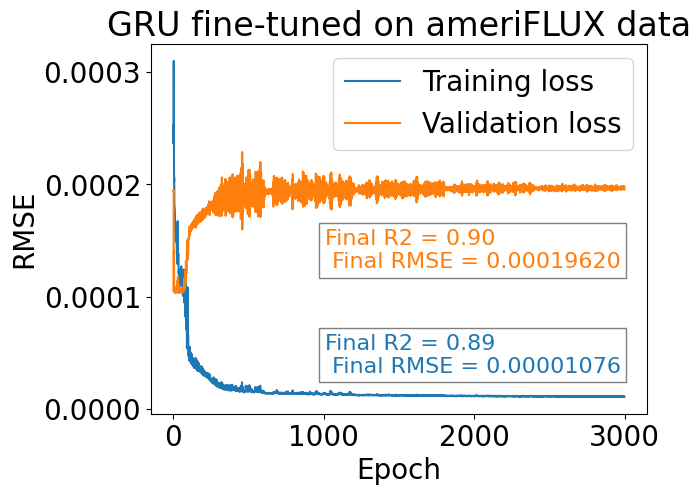

In [34]:
checkpoint=torch.load('kgml-results/stats-fine_tuned')
train_losses=checkpoint['train_losses']
val_losses=checkpoint['val_losses']
plt.rcParams.update({'font.size': 20})
plt.rcParams['xtick.labelsize']=20
plt.rcParams['ytick.labelsize']=20
fig= plt.plot(figsize=(6, 10)) 
train_line, = plt.plot(train_losses, label="Training loss") 
val_line, = plt.plot(val_losses, label="Validation loss")
plt.title("GRU fine-tuned on ameriFLUX data")
plt.text(0.35, 0.1, "Final R2 = %0.2f\n Final RMSE = %0.8f" % (train_R2, train_loss), ha="left", va="bottom", color=train_line.get_color(), fontsize=16, transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))
plt.text(0.35, 0.5, "Final R2 = %0.2f\n Final RMSE = %0.8f" % (val_R2, val_loss), ha="left", va="top", color=val_line.get_color(), fontsize=16, transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))
plt.ylabel("RMSE")
plt.xlabel("Epoch")
plt.legend()